In [1]:
import numpy as np 
from scipy.special import softmax 
import time 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [2]:
## simpler layout
layout = [
    "S.......",
    "........",
    "........",
    "........",
    "...H....",
    ".HH.....",
    ".H..H...",
    "...H...G"
]
lr_curves = {}

In [3]:
def show_lr_curves(model_performances, window_size=100):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    for lbl, curve in model_performances.items():
        # smooth the learning curve 
        smoothed_curve = np.convolve(curve, np.ones(window_size)/window_size, mode='valid')
        t = np.arange(len(smoothed_curve))
        sns.lineplot(x=t, y=smoothed_curve, ax=ax, label=lbl)
    for pos in ['left', 'bottom']: ax.spines[pos].set_linewidth(3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim([0, 105])
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Steps')
    plt.show()

In [4]:
seed = 1234 
env = frozen_lake(seed=seed, layout=layout, Rscale=10)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

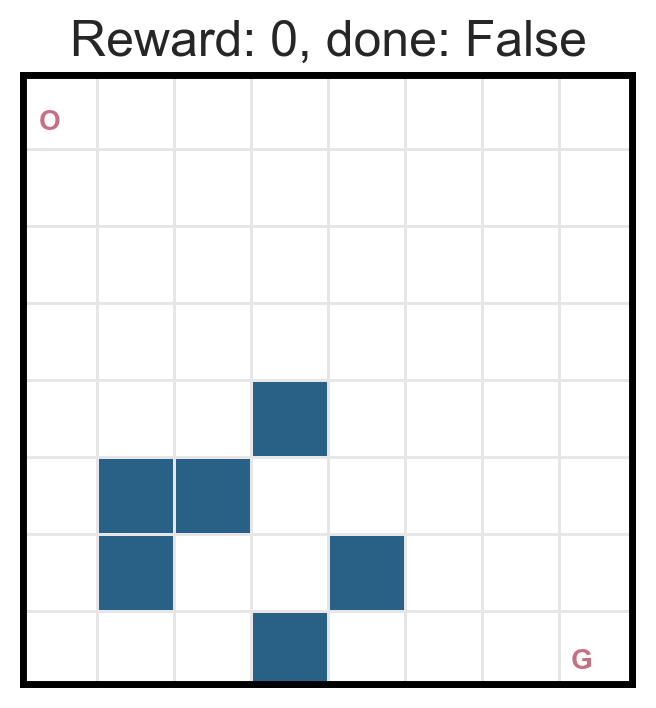

In [5]:
plt.show()

# 介绍一下这个frozen_lake的游戏
* env.reset() 重置agent的位置到起始点
* env.step(a) a=[0, 1, 2, 3,] 代表上下左右
* env.p_s_next(s, a) 输入当前state s 和 action a, 输出转移到所有其他state的概率的向量
* env.r(s) 到达某个state时，返回(reward, bool done or not)
* env.s_termination 返回所有的终点的state, 包括窟窿和终点
* env.show_v(ax, V)  把所有状态的value画出来
* env.A, env.S 展示所有的action和state

## 1. Monte Carlo Methods

## 1.1 Greedy control for MC method 

In [6]:
class greedy:
    '''greedy policy that returns the action 
    with the highest probability (with arbitrary tie-breaking)
    
    for example:
        given q[s] = [.3, .9, .9, .1], the 2nd and 3rd action are tied,
        then the policy should be [0, .5, .5, 0]
    '''
    def __init__(self, n_episodes):
        self.n_episodes = n_episodes

    def __call__(self, q):
        #########################################
        # TODO: greedy policy with arbitrary 
        #        tie-breaking
        #########################################
        q=(q == np.max(q)).astype(float)
        q=q/np.sum(q)
        return q

In [13]:
def MC_method(env, pi, policy_strategy, n_episodes=10000, 
                gamma=.99, seed=1234, 
                show_trajectory=False,
                show_intval=2000, max_steps=100):
    # policy strategy是选择策略的策略，这里输入的就是上面写的greedy函数
    # initialize random seed
    rng = np.random.RandomState(seed)
    q = np.zeros([env.nS, env.nA])
    v = np.sum(pi*q, axis=1)
    cumu_rewards = {(s, a): [] for s in env.S for a in env.A} 
    # init a list to record the model performance per episode
    model_performance = []

    # initialize the policy strategy
    policy = policy_strategy(n_episodes)

    # loop over episodes
    for epi in range(n_episodes):
        trajectory = []
        policy.epi = epi # 不知道这一步有什么用，可能是来记录epi吧

        # rollout the episode 
        s, _, _ = env.reset()
        step = 0
        while True:
            a = rng.choice(env.A, p=pi[s])
            s_next, r, done = env.step(a)
            trajectory.append((s, a, r))
            s = s_next
            step += 1
           
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v)
                env.show_pi(ax[2], pi)
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                model_performance.append(step)
                break

        # calculate the cumulative rewards
        G, T = 0, len(trajectory)
        for j, step in enumerate(reversed(trajectory)):
            s, a, r = step
            G = gamma*G + r
            # check if first visit
            prev_visit = [(si, ai) for si, ai, _ in trajectory[:T-j-1]]
            if (s, a) not in prev_visit:
                #############################
                # TODO: update the q value 
                #############################
                cumu_rewards[(s,a)].append(G)
                q[s,a]=np.mean(cumu_rewards[(s,a)])
                #############################
                # TODO: update the policy 
                #############################
                pi[s]=policy(q[s])
                # calculate the value function (just for visualization)
                v[s] = np.sum(pi[s]*q[s])

    return q, pi, model_performance

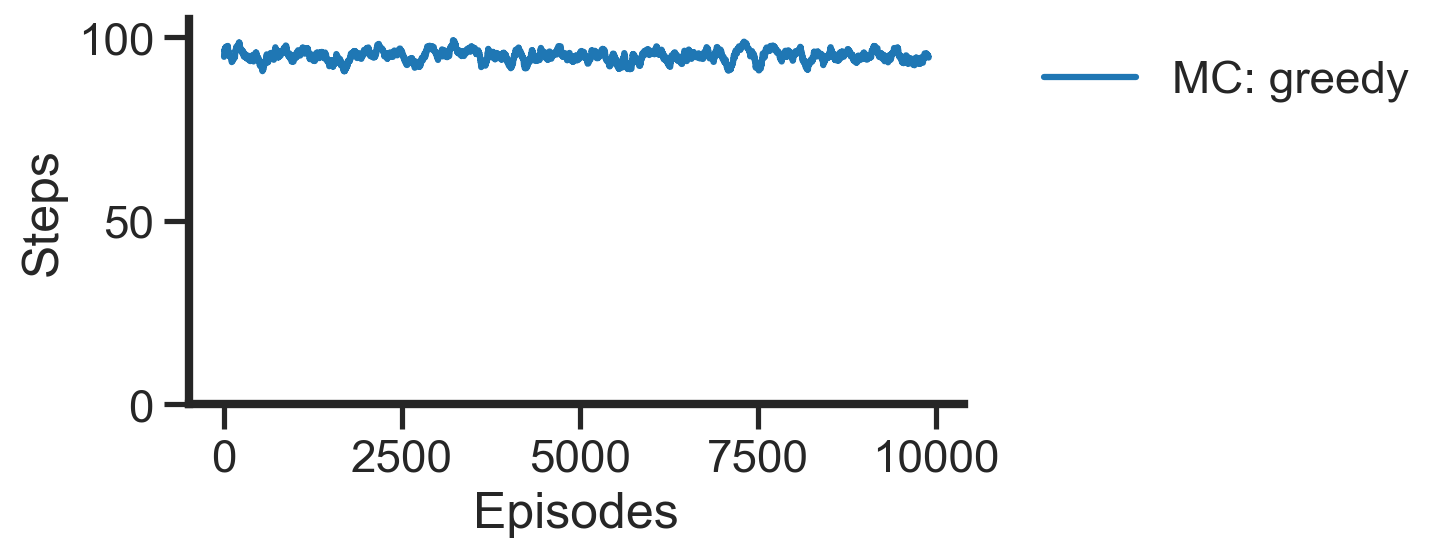

In [12]:
# create the random policy
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
env = frozen_lake(seed=seed, layout=layout, Rscale=10)
q_gd, pi_gd, mp_gd = MC_method(env, pi_rand, 
                            policy_strategy=greedy, 
                            show_trajectory=False,
                            n_episodes=10000)
lr_curves['MC: greedy'] = mp_gd
show_lr_curves(lr_curves)


## 1.2 Epsilon-greedy policy for MC method


In [14]:
class e_greedy:
    '''epsilon-greedy policy

    The policy has epsilon probability to choose a random action,

    for example
        given q[s] = [.3, .9, .9, .1], the 2nd and 3rd action are tied,
        then the greedy policy should be [0, .5, .5, 0]

        assuming that epsilon = 0.1, then the policy should be 

        [0.025, 0.475, 0.475, 0.025]
    '''
    def __init__(self, n_episodes, eps=0.3):
        self.n_episodes = n_episodes
        self.eps = eps # eps is the epsilon

    def __call__(self, q):
        #########################################
        # TODO: epsilon-greedy policy
        #########################################
        # random policy
        pi_rand = np.ones(env.nA) / env.nA
        # greedy policy 
        qmax = q==np.max(q)
        pi_greedy = qmax / qmax.sum()
        return self.eps*pi_rand + (1-self.eps)*pi_greedy

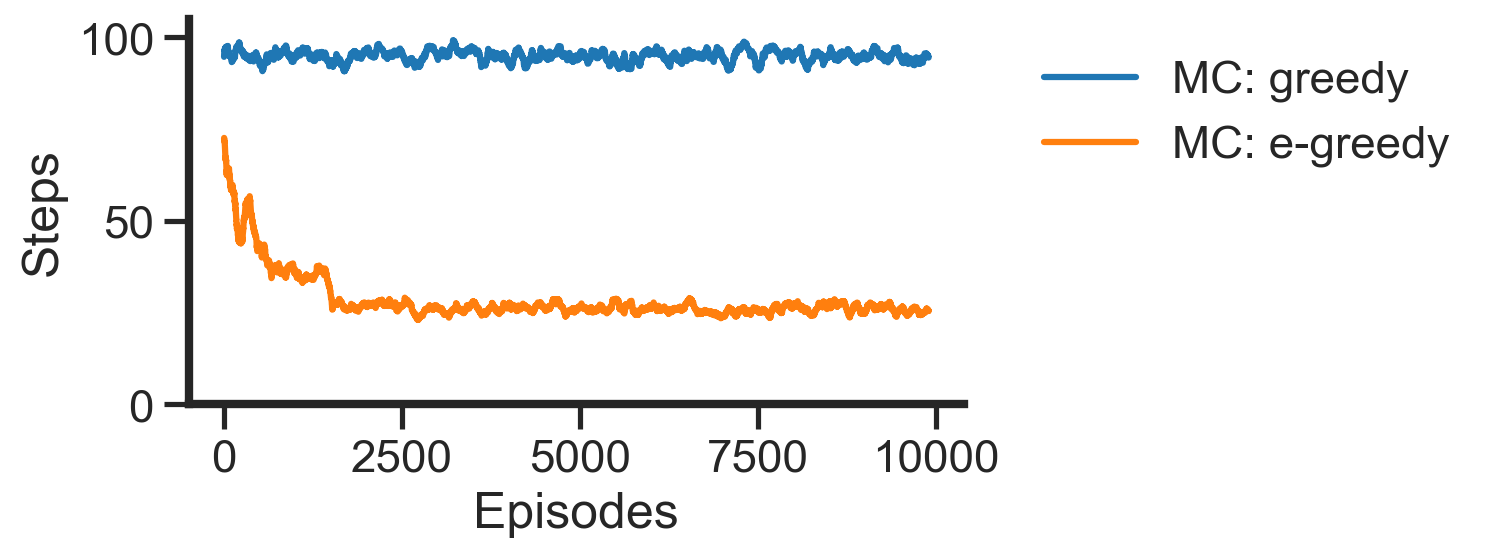

In [15]:
# create the random policy
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
env = frozen_lake(seed=seed, layout=layout, Rscale=10)
q_eg, pi_eg, mp_eg = MC_method(env, pi_rand,
                               policy_strategy=e_greedy, 
                               show_trajectory=False,
                               n_episodes=10000)
lr_curves['MC: e-greedy'] = mp_eg
show_lr_curves(lr_curves)


## 1.3 Epsilon-greedy policy with decaying epsilon

In [16]:
class e_greedy_decay:
    '''epsilon-greedy policy with decaying epsilon

    The epsilon decays from eps0 to eps1 over n_episodes
    in a linear decay:
        eps = eps0*(1-epi/n_episodes)+eps1
    
    '''
    def __init__(self, n_episodes, eps0=0.5, eps1=0.1):
        self.n_episodes = n_episodes
        self.epi  = 0
        self.eps0 = eps0-eps1
        self.eps1 = eps1

    def __call__(self, q):
        #########################################
        # TODO: epsilon-greedy policy with 
        #       decaying epsilon using 
        #    eps = eps0*(1-epi/n_episodes)+eps1
        #########################################
        # random policy
        pi_rand = np.ones(env.nA) / env.nA
        # greedy policy 
        qmax = q==np.max(q)
        pi_greedy = qmax / qmax.sum()
        eps = self.eps0*(1-self.epi/self.n_episodes)+self.eps1
        return eps*pi_rand + (1-eps)*pi_greedy

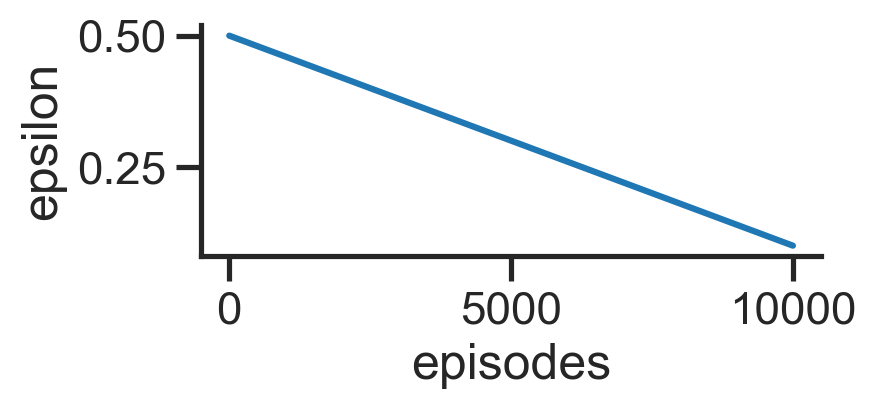

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 1.5))
eps0, eps1 = 0.4, 0.1
n_episodes = 10000
epi = np.arange(n_episodes)
eps_decay = eps0*(1-epi/n_episodes)+eps1
sns.lineplot(x=epi, y=eps_decay, ax=ax)
ax.set_xlabel('episodes')
ax.set_ylabel('epsilon')
plt.show()

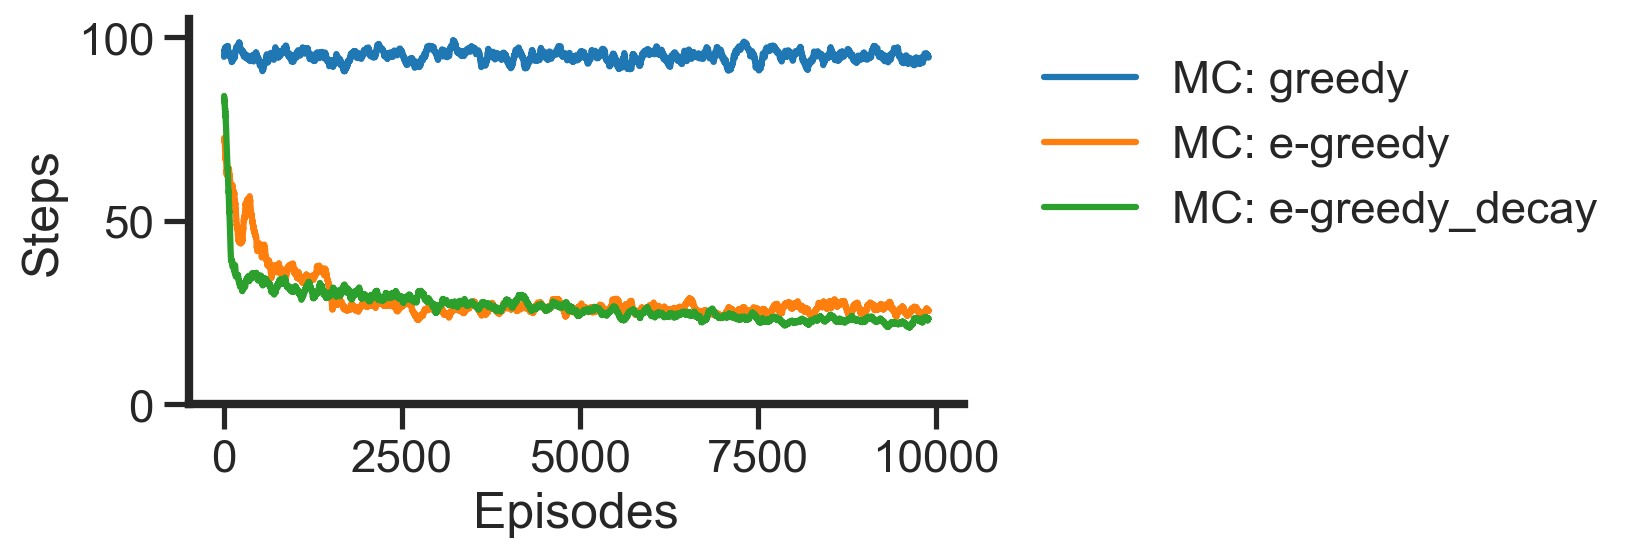

In [17]:
# create the random policy
rng = np.random.RandomState(1234)
pi_rand = softmax(rng.rand(env.nS, env.nA)*5, axis=1)
env = frozen_lake(seed=seed, layout=layout, Rscale=10)
q_egd, pi_egd, mp_egd = MC_method(env, pi_rand,
                               policy_strategy=e_greedy_decay, 
                               show_trajectory=False,
                               n_episodes=10000)
lr_curves['MC: e-greedy_decay'] = mp_egd
show_lr_curves(lr_curves)

## TD learning 

###  2.1 Sarsa

In [19]:
def Sarsa(env, pi, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, n_episodes=15000, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100):
    
    # initialization 
    rng = np.random.RandomState(seed)
    q = np.zeros([env.nS, env.nA])
    v = np.zeros([env.nS])
    policy = policy_strategy(n_episodes)
    model_performance = []

    # loop over episodes 
    for epi in range(n_episodes):
        policy.epi = epi
        s, _, _ = env.reset()
        a = rng.choice(env.A, p=pi[s])
        step = 0
        while True:
            ##########################################
            # TODO: rollout the episode, 
            #         get r, s_next and a_next
            ##########################################
            s_next, r, done = env.step(a)
            a_next = rng.choice(env.A, p=pi[s_next])
            ##########################################
            # TODO: update q value using 
            #         sarsa update 
            ##########################################
            q[s,a]=q[s,a]+alpha*(r+(1-done)*gamma*q[s_next, a_next]-q[s,a])
            ##########################################
            # TODO: improve policy 
            ##########################################
            pi[s]=policy(q[s])
            # calculate the value function (just for visualization)
            v[s] = np.sum(pi[s]*q[s])  
            s, a = s_next, a_next
            step += 1
            
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v)
                env.show_pi(ax[2], pi)
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                model_performance.append(step)
                break

    return q, pi, model_performance

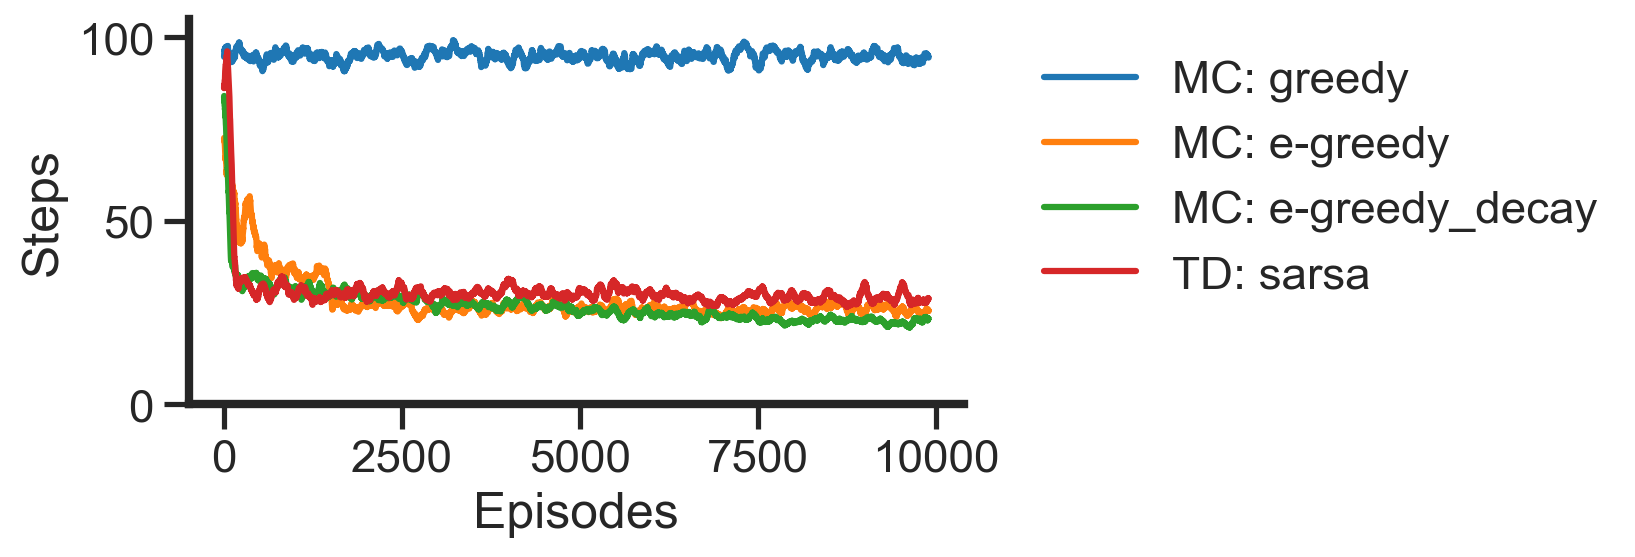

In [20]:
seed = 1234 
rng = np.random.RandomState(seed)
pi_rand = softmax(np.zeros([env.nS, env.nA]), axis=1)
env = frozen_lake(seed=seed, layout=layout, Rscale=10)
q_sarsa, pi_sarsa, pg_sarsa = Sarsa(env, pi_rand, 
                                    policy_strategy=e_greedy, 
                                    show_trajectory=False,
                                    n_episodes=10000)
lr_curves['TD: sarsa'] = pg_sarsa
show_lr_curves(lr_curves)

### 2.2 Sarsa in the old environment

In [21]:
# use the old environment
lr_curves_old = {}
seed = 1234 
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

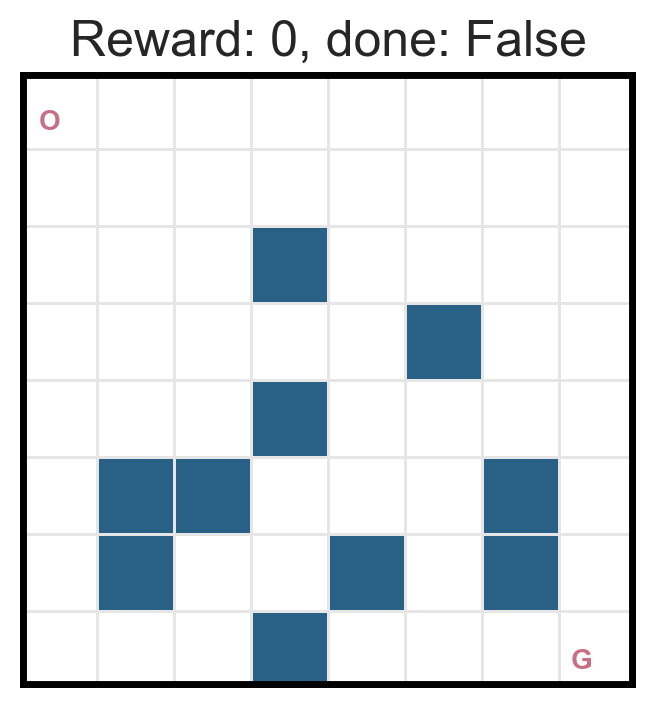

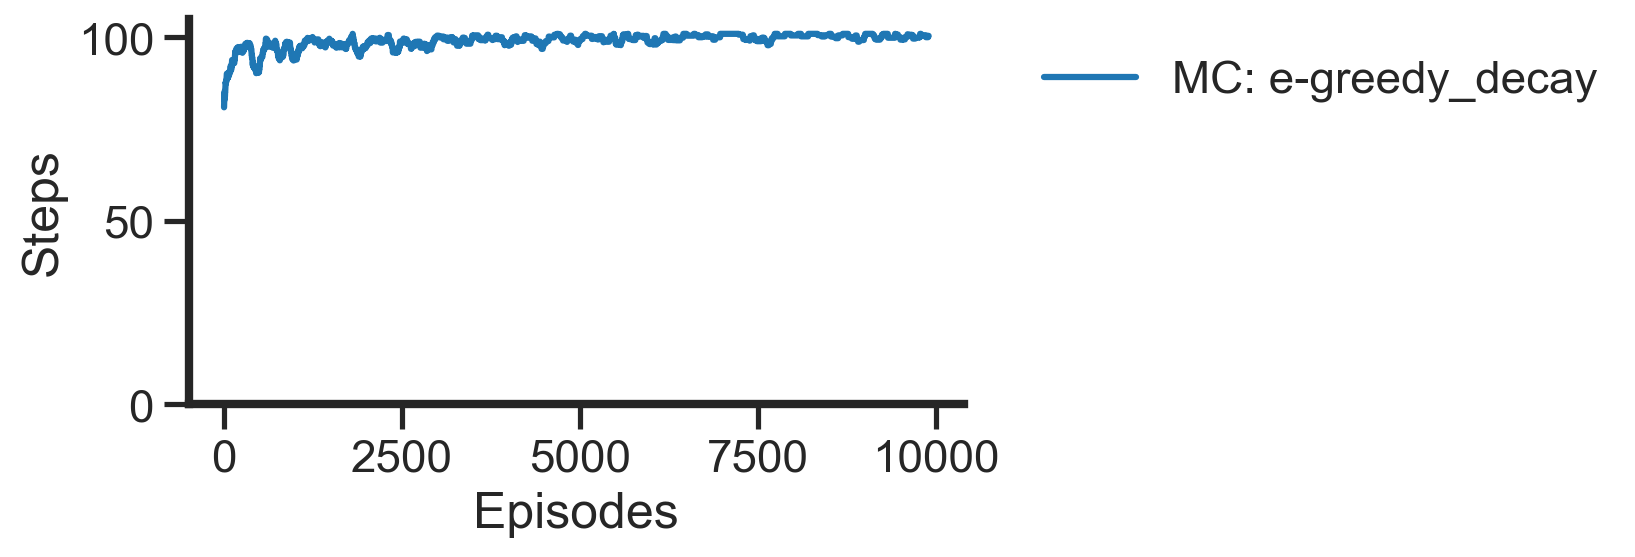

In [22]:
# epilon-greedy with decaying epsilon
seed = 1234
rng = np.random.RandomState(seed)
pi_rand = softmax(np.zeros([env.nS, env.nA]), axis=1)
env = frozen_lake(seed=seed, Rscale=10)
q_sarsa, pi_sarsa, mp_sarsa = MC_method(env, pi_rand, 
                                policy_strategy=e_greedy_decay, 
                                show_trajectory=False,
                                n_episodes=10000)
lr_curves_old['MC: e-greedy_decay'] = mp_sarsa
show_lr_curves(lr_curves_old)

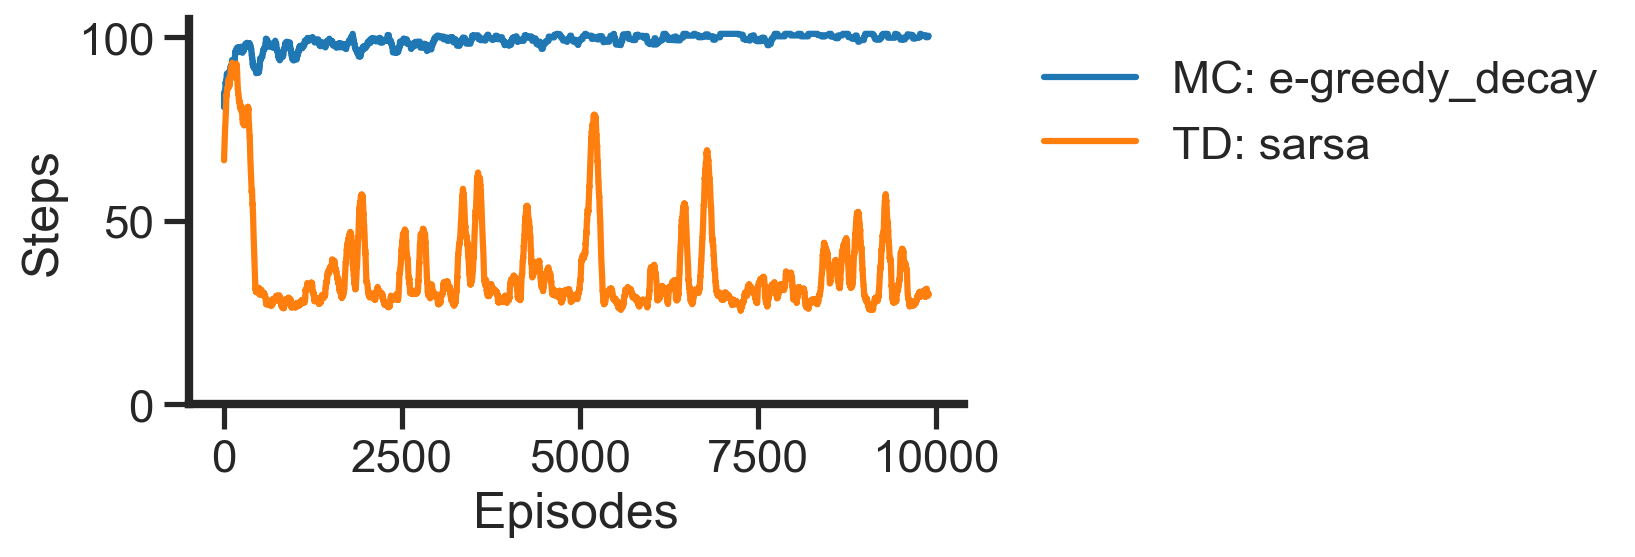

In [23]:
seed, lr_curves = 1234, {}
rng = np.random.RandomState(seed)
pi_rand = softmax(np.zeros([env.nS, env.nA]), axis=1)
env = frozen_lake(seed=seed, Rscale=10)
q_sarsa, pi_sarsa, mp_sarsa = Sarsa(env, pi_rand, 
                                policy_strategy=e_greedy, 
                                show_trajectory=False,
                                n_episodes=10000)
lr_curves_old['TD: sarsa'] = mp_sarsa
show_lr_curves(lr_curves_old)

### 2.2 Q learning

In [24]:
def Qlearn(env, pi, policy_strategy, alpha=.1, gamma=.99, 
                  seed=1234, n_episodes=15000, 
                  show_trajectory=False, 
                  show_intval=1000, max_steps=100):
    
    # initialization 
    rng = np.random.RandomState(seed)
    q = np.zeros([env.nS, env.nA])
    v = np.zeros([env.nS])
    policy = policy_strategy(n_episodes)
    model_performance = []

    # loop over episodes 
    for epi in range(n_episodes):
        policy.epi = epi
        s, _, _ = env.reset()
        # a = rng.choice(env.A, p=pi[s])
        step = 0
        while True:
            ##########################################
            # TODO: rollout the episode, 
            #         get a, r, s_next
            ##########################################
            a = rng.choice(env.A, p=pi[s])
            s_next, r, done = env.step(a)
            ##########################################
            # TODO: update q value using 
            #         q-learning update 
            ##########################################
            q[s,a]=q[s,a]+alpha*(r+(1-done)*gamma*np.max(q[s_next])-q[s,a])
            ##########################################
            # TODO: improve policy 
            ##########################################
            pi[s]=policy(q[s])
            # calculate the value function (just for visualization)
            v[s] = np.sum(pi[s]*q[s])  
            s = s_next
            step += 1
            
            if show_trajectory and (epi%show_intval==0):
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                clear_output(True)
                env.render(ax[0], epi+1, step)
                env.show_v(ax[1], v)
                env.show_pi(ax[2], pi)
                time.sleep(.1)
                plt.show()

            if done or (step>max_steps): 
                model_performance.append(step)
                break

    return q, pi, model_performance

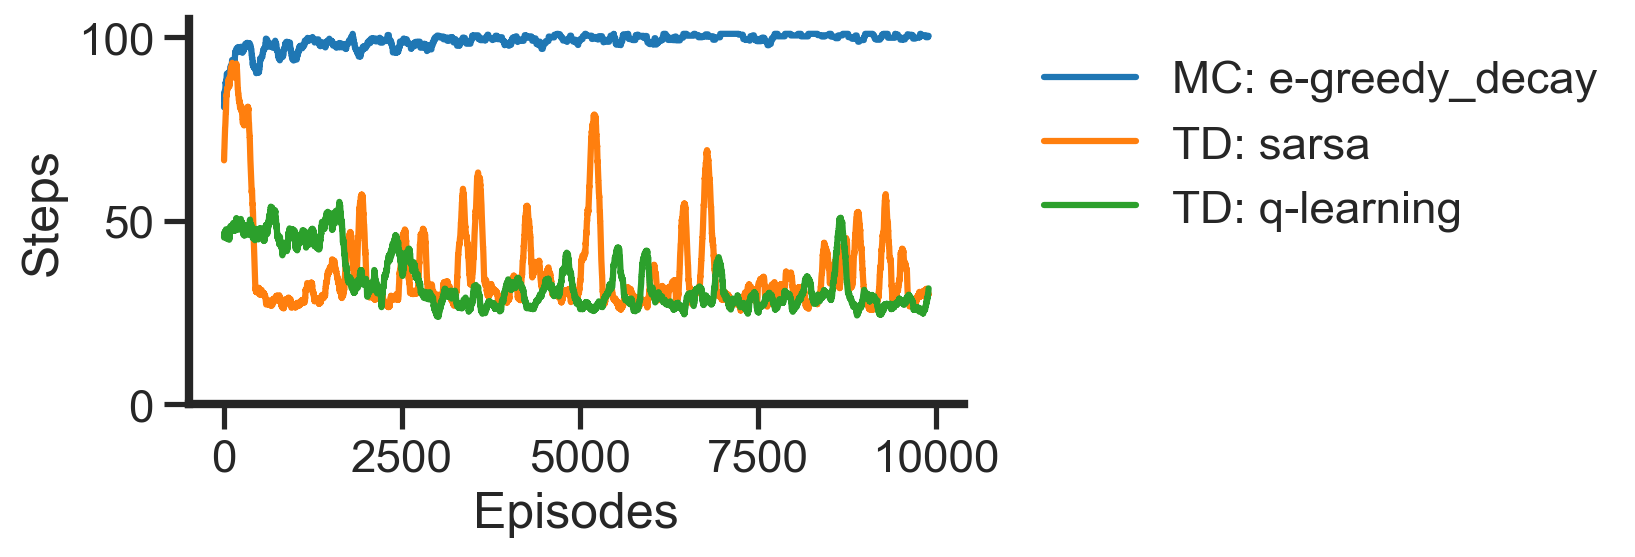

In [25]:
seed = 1234
rng = np.random.RandomState(seed)
pi_rand = softmax(np.zeros([env.nS, env.nA]), axis=1)
env = frozen_lake(seed=seed, Rscale=10)
q_ql, pi_ql, mp_ql = Qlearn(env, pi_rand, 
                            policy_strategy=e_greedy, 
                            show_trajectory=False,
                            n_episodes=10000)
lr_curves_old['TD: q-learning'] = mp_ql
show_lr_curves(lr_curves_old)
